In [753]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from autoencoder import create_encoders, create_conv_encoders, fit_encoders, create_full_model, fit_full_model, create_fc_layers
from preprocess import load_clean_data, data_stats, plot_samples, plot_avg, plot_ewma, create_features, create_features_labels 
from plots import plot_validation_diagram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [754]:
data = load_clean_data([0, 1])
validation = load_clean_data([3])

In [289]:
#data_stats(data)

In [158]:
#plot_samples(data)

In [159]:
#plot_avg(data[0]['signals'], 400)

In [160]:
#plot_ewma(data[0]['signals'], 400)

### autoencoder data

In [755]:
beats = create_features(data, 784)
x_train_beats, x_test_beats = train_test_split(beats, test_size = 0.2, random_state = 0)

### full model data

In [756]:
lb = LabelBinarizer()
x_train, labels = create_features_labels(data, 784, non_beats_per_beat=2)
y_train = lb.fit_transform(labels)

x_test, labels = create_features_labels(validation, 784, non_beats_per_beat=2)
y_test = lb.transform(labels)

#x_train, x_test, y_train, y_test = train_test_split(features, bin_labels, test_size = 0.2, random_state = 0)

In [158]:
x_train.shape, x_test.shape

((12387, 784), (6246, 784))

In [157]:
print(lb.classes_)

['A' 'N' 'NB']


In [151]:
ann = data[0]['annotations']
sig = data[0]['signals']

In [757]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

In [160]:
ann[ann['Type'] == 'A']

,Time,Sample,Type
1357,19:21.875,418275,A
1588,22:40.108,489639,A


In [789]:
def evaluate_full_model(encoder, config, epochs = 2):
    models = {}
    for layers_dim in config:
        model_name = str(layers_dim)
        print('Evaluating model with fc:', model_name)
        model = create_full_model(encoder, layers_dim)
        models[model_name] = model
        fit_full_model(model, x_train, x_test, y_train, y_test, epochs=epochs, verbose=0)
        plot_validation_diagram(model, lb.classes_, ann, sig, 500, 2500)        
        
    return models

In [759]:
def evaluate_nn_models(config, ae_epochs= 1, full_model_epochs = 1):
    models = {}    
    for layers_dim in config['ae']:
        ae_name = str(layers_dim)
        print('Running autoencoder with config:', ae_name)
        encoders = create_encoders(*layers_dim)        
        h = fit_encoders(encoders, x_train_beats, x_test_beats, epochs=ae_epochs, filename=ae_name + '.h5', load_prev=False)
        full_models = evaluate_full_model(encoders[1], config['fc'], epochs=full_model_epochs)
        models[ae_name] = {'encoders': encoders, 'full_models': full_models}
        
    return models

In [766]:
def evaluate_conv_models(config, ae_epochs= 1, full_model_epochs = 1):
    models = {}   
    ae_name = 'conv_16_8_8'
    print('Running convolution autoencoder with config:', ae_name)
    encoders = create_conv_encoders()    
    h = fit_encoders(encoders, x_train_beats, x_test_beats, epochs=ae_epochs, filename=ae_name + '.h5', load_prev=False)
    full_models = evaluate_full_model(encoders[1], config['fc'], epochs=full_model_epochs)
    models[ae_name] = {'encoders': encoders, 'full_models': full_models}
        
    return models

('Running convolution autoencoder with config:', 'conv_16_8_8')


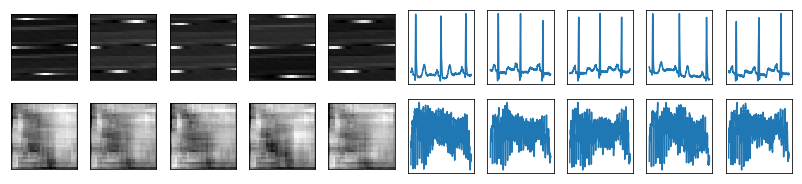

(None, 4, 4, 8)
('Evaluating model with fc:', '[3]')
[(None, 28, 28, 1), (None, 4, 4, 8), (None, 128), (None, 3)]


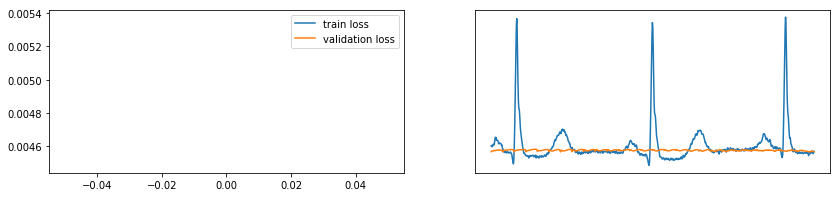

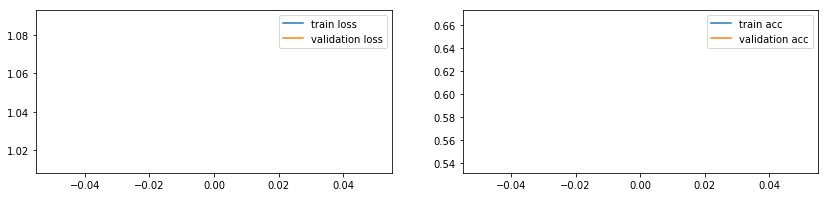

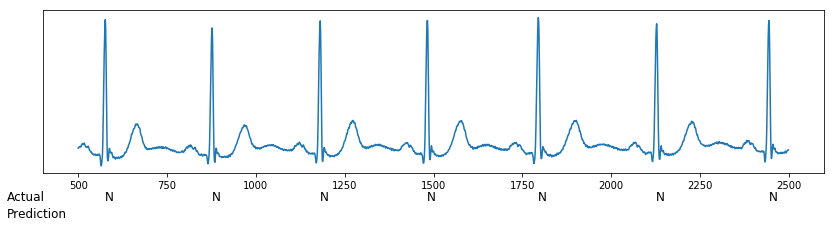

('Evaluating model with fc:', '[10, 3]')
[(None, 28, 28, 1), (None, 4, 4, 8), (None, 128), (None, 10), (None, 3)]


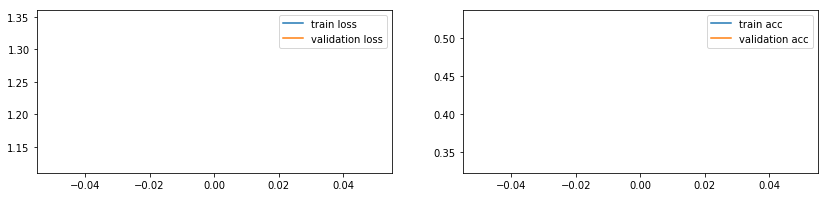

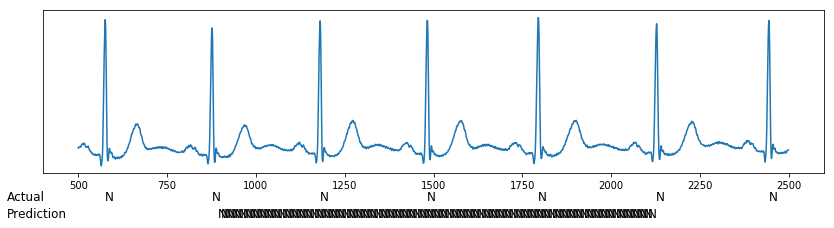

('Evaluating model with fc:', '[32, 3]')
[(None, 28, 28, 1), (None, 4, 4, 8), (None, 128), (None, 32), (None, 3)]


KeyboardInterrupt: 

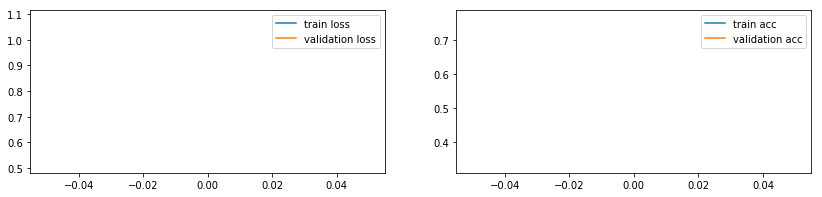

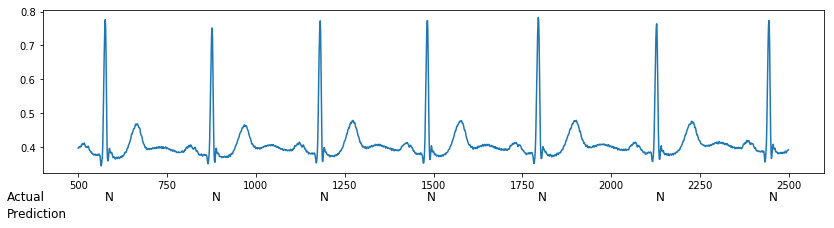

In [781]:
config = {
    'ae' : [ [784,[], 64], [784, [256, 128], 64], [784, [512], 64] ],
    'fc' : [ [3], [10,3], [32,3], [64,3] ]
}
evaluate_conv_models(config)

('Running autoencoder with config:', '[784, [], 64]')


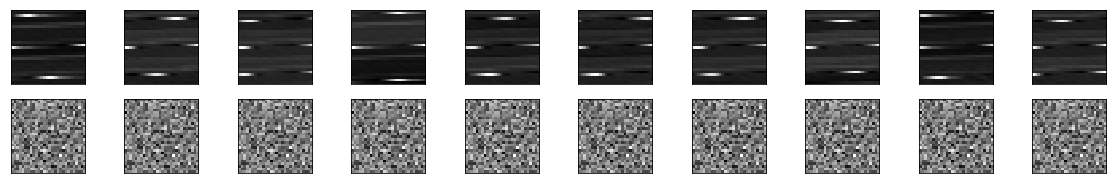

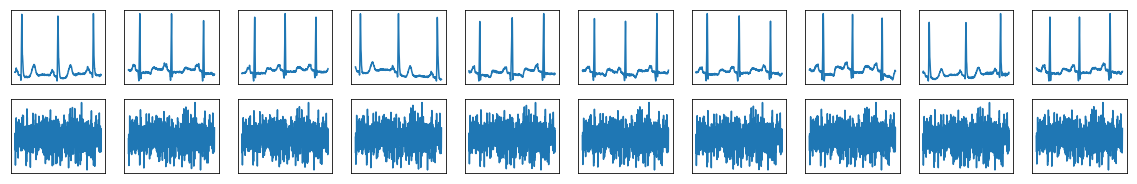

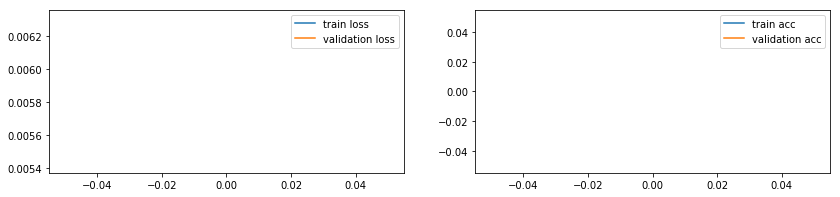

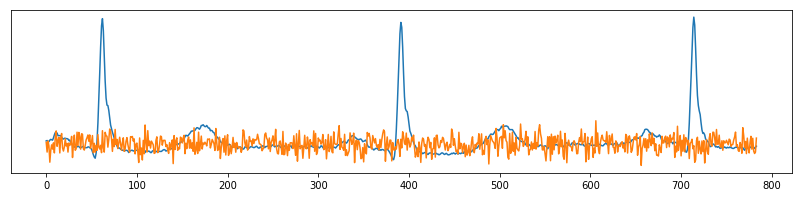

('Evaluating model with fc:', '[3]')


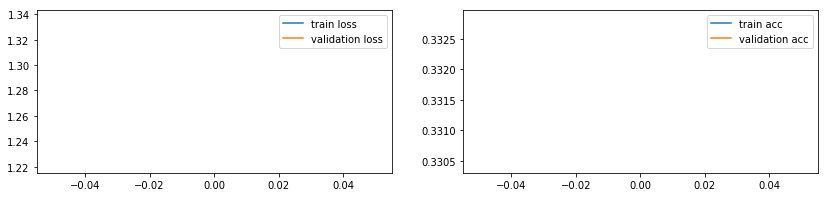

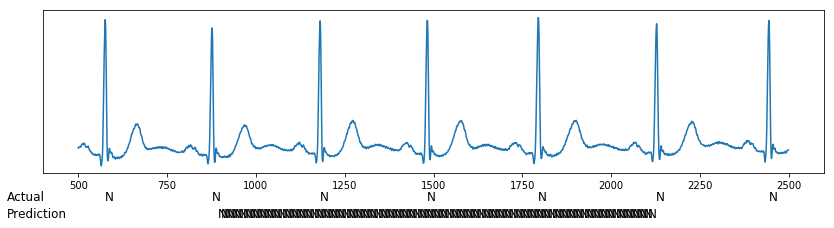

('Evaluating model with fc:', '[10, 3]')


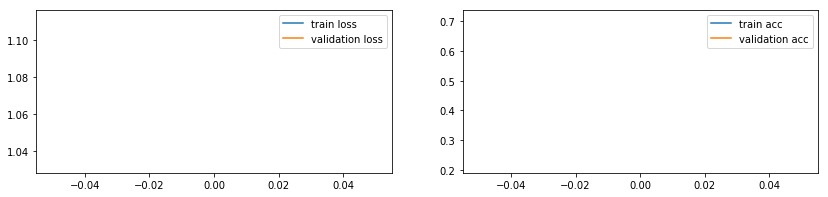

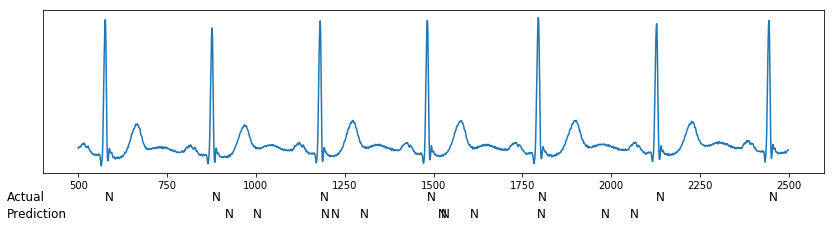

('Evaluating model with fc:', '[32, 3]')


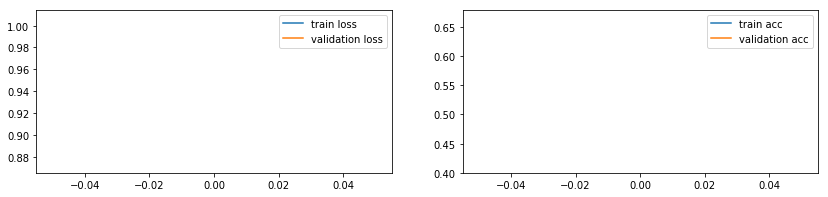

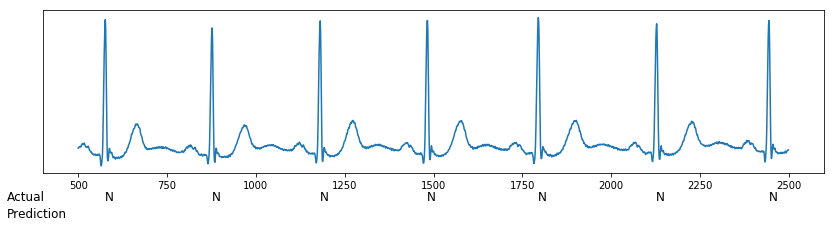

('Evaluating model with fc:', '[64, 3]')


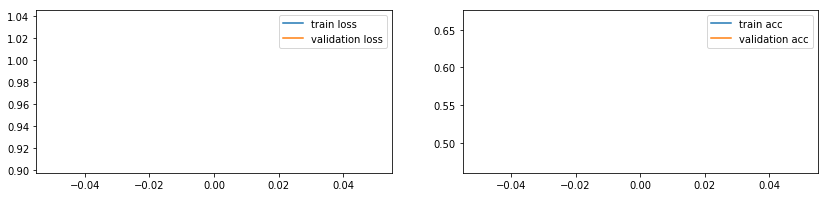

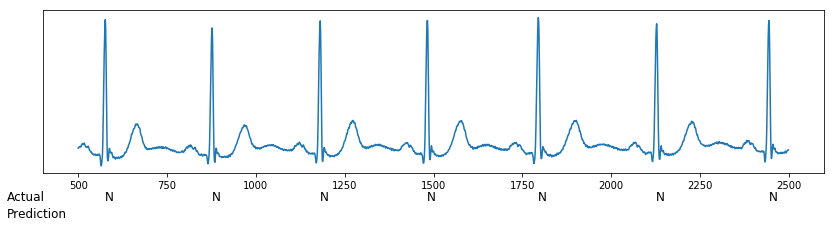

('Running autoencoder with config:', '[784, [256, 128], 64]')


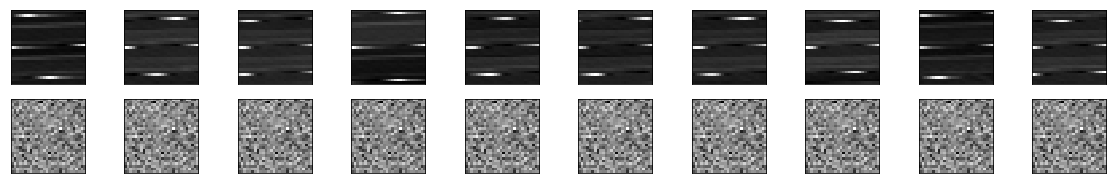

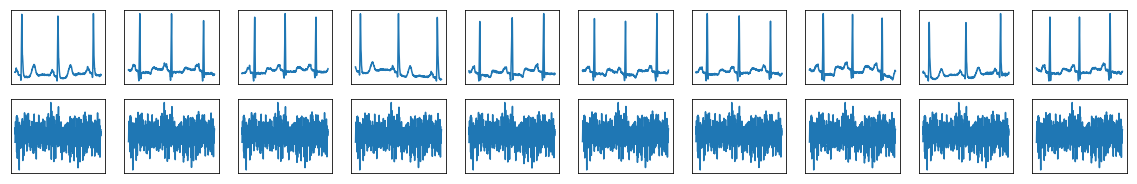

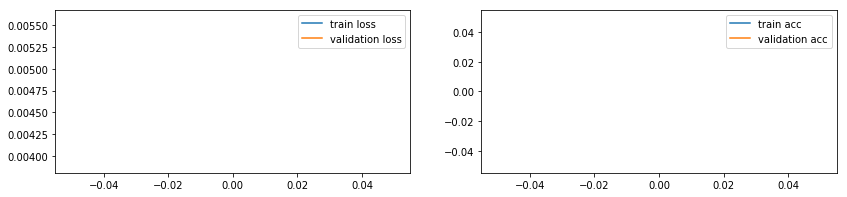

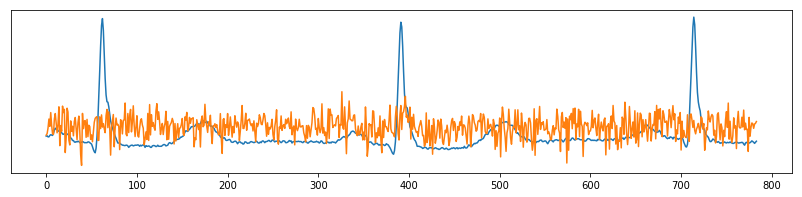

('Evaluating model with fc:', '[3]')


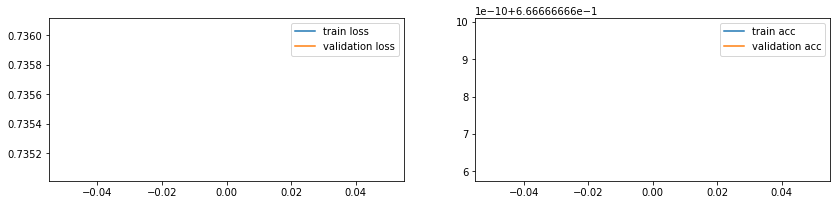

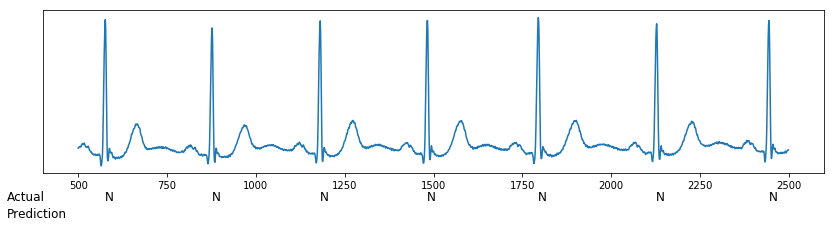

('Evaluating model with fc:', '[10, 3]')


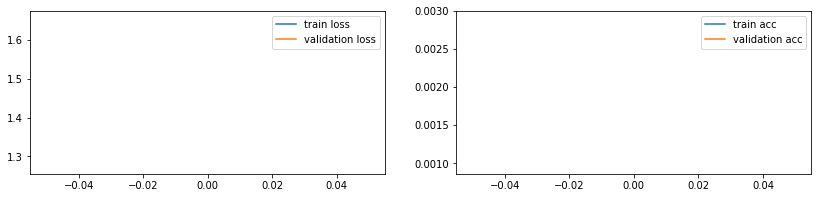

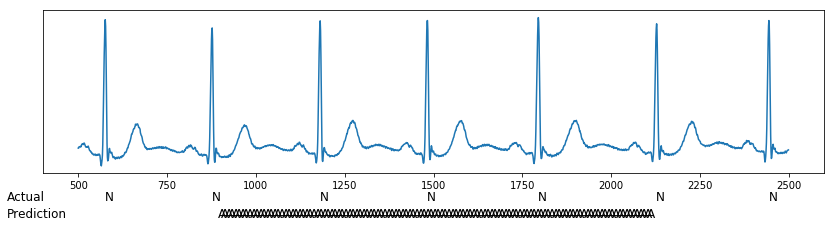

('Evaluating model with fc:', '[32, 3]')


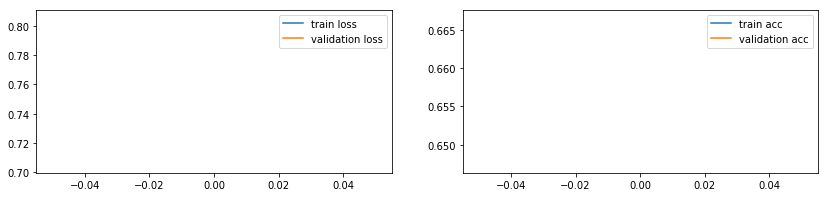

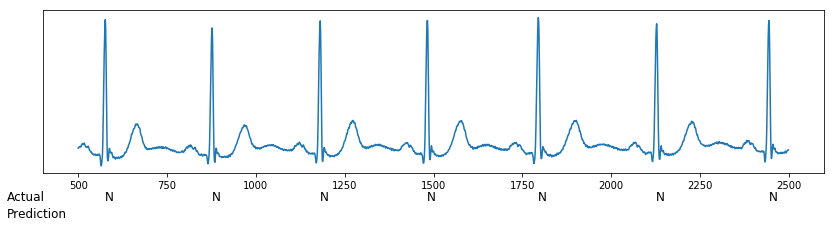

('Evaluating model with fc:', '[64, 3]')


KeyboardInterrupt: 

In [761]:
config = {
    'ae' : [ [784,[], 64], [784, [256, 128], 64], [784, [512], 64] ],
    'fc' : [ [3], [10,3], [32,3], [64,3] ]
}
evaluate_nn_models(config)

### 784 64

In [784]:
encoders = create_encoders(784, [], 64)

Successfully loaded weights
Train on 12387 samples, validate on 6246 samples
Epoch 1/100
12387/12387 [==============================] - 3s - loss: 0.0035 - acc: 0.0455 - val_loss: 0.0035 - val_acc: 0.0144
Epoch 2/100
12387/12387 [==============================] - 0s - loss: 0.0018 - acc: 0.0421 - val_loss: 0.0032 - val_acc: 0.0251
Epoch 3/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0426 - val_loss: 0.0032 - val_acc: 0.0261
Epoch 4/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0417 - val_loss: 0.0032 - val_acc: 0.0258
Epoch 5/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0411 - val_loss: 0.0032 - val_acc: 0.0261
Epoch 6/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0413 - val_loss: 0.0032 - val_acc: 0.0263
Epoch 7/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0416 - val_loss: 0.0032 - val_acc: 0.0263
Epoch 8/100
12387/12387 [==

12387/12387 [==============================] - 0s - loss: 0.0016 - acc: 0.0409 - val_loss: 0.0030 - val_acc: 0.0267
Epoch 64/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0405 - val_loss: 0.0029 - val_acc: 0.0261
Epoch 65/100
12387/12387 [==============================] - 0s - loss: 0.0016 - acc: 0.0405 - val_loss: 0.0030 - val_acc: 0.0264
Epoch 66/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0412 - val_loss: 0.0029 - val_acc: 0.0264
Epoch 67/100
12387/12387 [==============================] - 0s - loss: 0.0016 - acc: 0.0406 - val_loss: 0.0029 - val_acc: 0.0259
Epoch 68/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0409 - val_loss: 0.0029 - val_acc: 0.0258
Epoch 69/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0406 - val_loss: 0.0030 - val_acc: 0.0264
Epoch 70/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0401 - val_loss: 0.0029

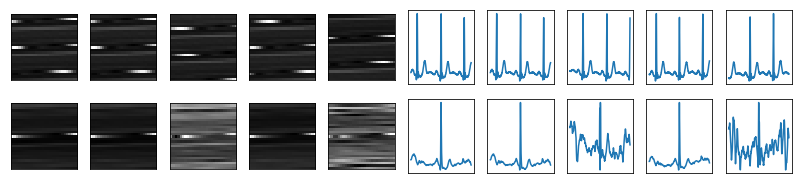

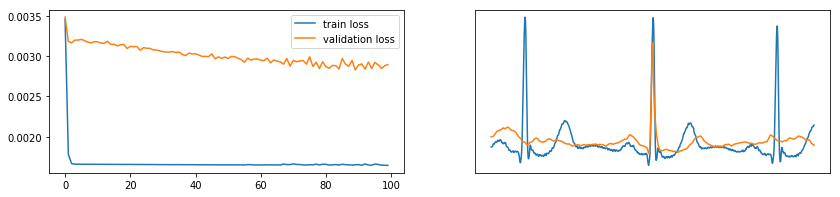

In [787]:
h = fit_encoders(encoders, x_train, x_test, epochs=100, filename='784_64.h5', load_prev=True, verbose=1)

In [85]:
#full_model = create_full_model(encoders[1], layers_dim=[64, 3])
#fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=100, verbose=0)
#plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

(None, 64)
('Evaluating model with fc:', '[3]')
[(None, 784), (None, 64), (None, 3)]


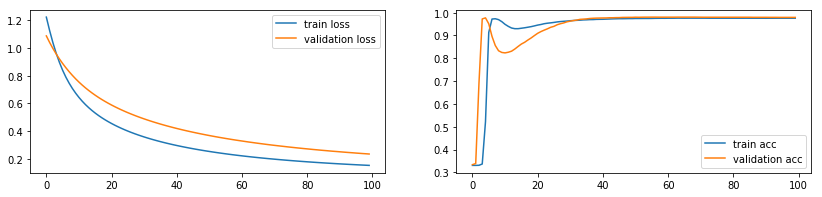

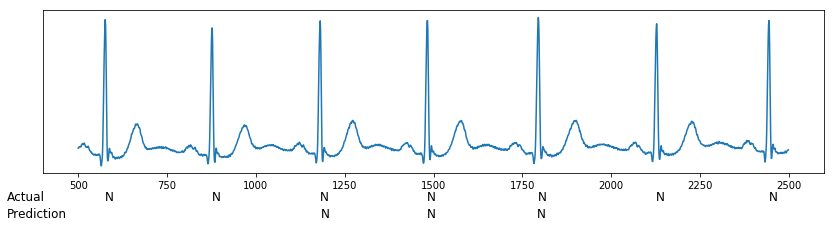

('Evaluating model with fc:', '[10, 3]')
[(None, 784), (None, 64), (None, 10), (None, 3)]


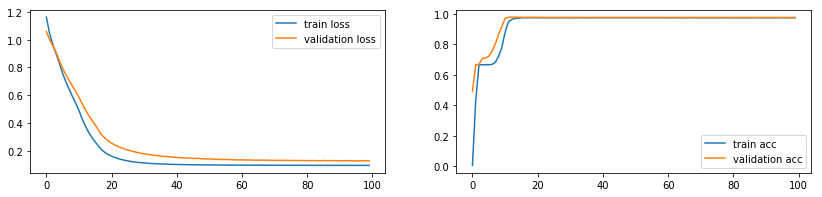

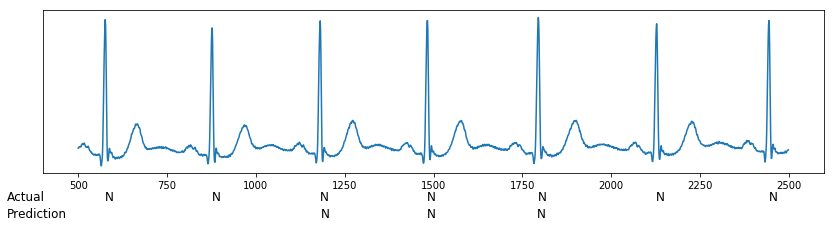

('Evaluating model with fc:', '[32, 3]')
[(None, 784), (None, 64), (None, 32), (None, 3)]


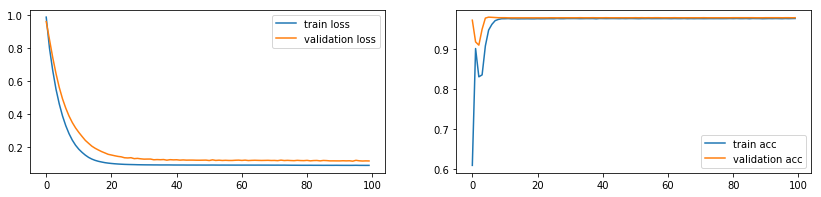

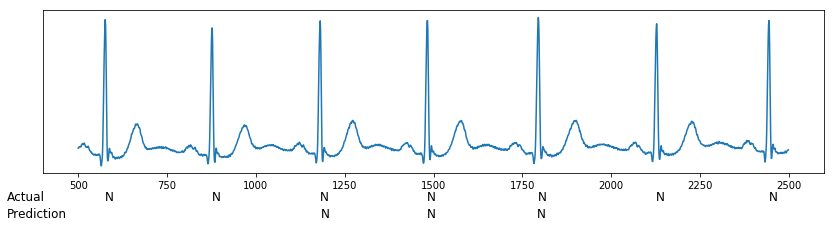

('Evaluating model with fc:', '[64, 3]')
[(None, 784), (None, 64), (None, 64), (None, 3)]


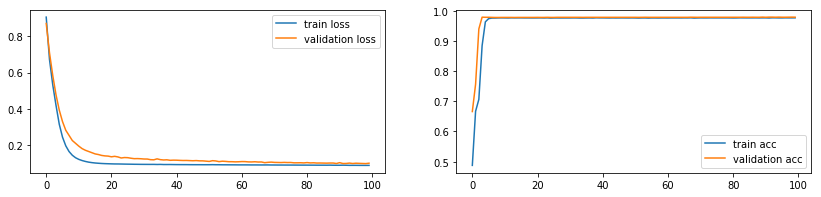

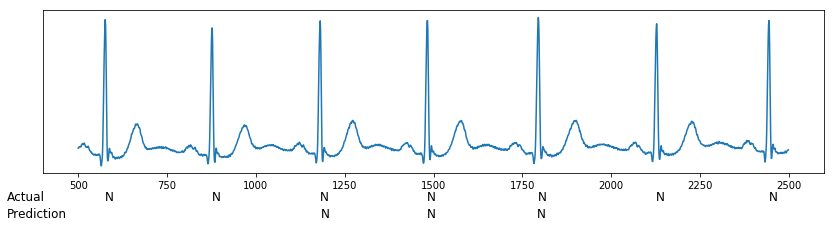

In [788]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

### 784 256 128 64

In [792]:
encoders = create_encoders(784, [256, 128], 64)

Train on 12387 samples, validate on 6246 samples
Epoch 1/200
12387/12387 [==============================] - 4s - loss: 0.0031 - acc: 0.0240 - val_loss: 0.0056 - val_acc: 0.0035
Epoch 2/200
12387/12387 [==============================] - 1s - loss: 0.0018 - acc: 0.0480 - val_loss: 0.0050 - val_acc: 0.0016
Epoch 3/200
12387/12387 [==============================] - 1s - loss: 0.0016 - acc: 0.0471 - val_loss: 0.0046 - val_acc: 0.0088
Epoch 4/200
12387/12387 [==============================] - 1s - loss: 0.0015 - acc: 0.0464 - val_loss: 0.0042 - val_acc: 0.0275
Epoch 5/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0509 - val_loss: 0.0040 - val_acc: 0.0285
Epoch 6/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0591 - val_loss: 0.0039 - val_acc: 0.0275
Epoch 7/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0600 - val_loss: 0.0038 - val_acc: 0.0248
Epoch 8/200
12387/12387 [==============================

12387/12387 [==============================] - 2s - loss: 0.0010 - acc: 0.0839 - val_loss: 0.0029 - val_acc: 0.0371
Epoch 65/200
12387/12387 [==============================] - 2s - loss: 0.0011 - acc: 0.0857 - val_loss: 0.0030 - val_acc: 0.0395
Epoch 66/200
12387/12387 [==============================] - 2s - loss: 0.0011 - acc: 0.0838 - val_loss: 0.0029 - val_acc: 0.0400
Epoch 67/200
12387/12387 [==============================] - 2s - loss: 0.0010 - acc: 0.0838 - val_loss: 0.0029 - val_acc: 0.0357
Epoch 68/200
12387/12387 [==============================] - 2s - loss: 0.0011 - acc: 0.0841 - val_loss: 0.0029 - val_acc: 0.0381
Epoch 69/200
12387/12387 [==============================] - 2s - loss: 0.0010 - acc: 0.0835 - val_loss: 0.0029 - val_acc: 0.0365
Epoch 70/200
12387/12387 [==============================] - 2s - loss: 0.0010 - acc: 0.0844 - val_loss: 0.0029 - val_acc: 0.0367
Epoch 71/200
12387/12387 [==============================] - 2s - loss: 0.0010 - acc: 0.0892 - val_loss: 0.0028

12387/12387 [==============================] - 2s - loss: 9.1847e-04 - acc: 0.1016 - val_loss: 0.0027 - val_acc: 0.0384
Epoch 127/200
12387/12387 [==============================] - 2s - loss: 9.0119e-04 - acc: 0.1016 - val_loss: 0.0027 - val_acc: 0.0365
Epoch 128/200
12387/12387 [==============================] - 3s - loss: 9.0051e-04 - acc: 0.1015 - val_loss: 0.0028 - val_acc: 0.0411
Epoch 129/200
12387/12387 [==============================] - 2s - loss: 9.1821e-04 - acc: 0.1014 - val_loss: 0.0027 - val_acc: 0.0363
Epoch 130/200
12387/12387 [==============================] - 2s - loss: 9.1693e-04 - acc: 0.1021 - val_loss: 0.0027 - val_acc: 0.0373
Epoch 131/200
12387/12387 [==============================] - 2s - loss: 9.0726e-04 - acc: 0.1004 - val_loss: 0.0026 - val_acc: 0.0376
Epoch 132/200
12387/12387 [==============================] - 2s - loss: 9.0229e-04 - acc: 0.1006 - val_loss: 0.0027 - val_acc: 0.0354
Epoch 133/200
12387/12387 [==============================] - 2s - loss: 9.09

12387/12387 [==============================] - 2s - loss: 8.1644e-04 - acc: 0.1111 - val_loss: 0.0026 - val_acc: 0.0371
Epoch 188/200
12387/12387 [==============================] - 2s - loss: 8.0703e-04 - acc: 0.1143 - val_loss: 0.0026 - val_acc: 0.0365
Epoch 189/200
12387/12387 [==============================] - 2s - loss: 8.2320e-04 - acc: 0.1184 - val_loss: 0.0027 - val_acc: 0.0373
Epoch 190/200
12387/12387 [==============================] - 2s - loss: 7.9900e-04 - acc: 0.1203 - val_loss: 0.0026 - val_acc: 0.0354
Epoch 191/200
12387/12387 [==============================] - 2s - loss: 8.1485e-04 - acc: 0.1162 - val_loss: 0.0026 - val_acc: 0.0381
Epoch 192/200
12387/12387 [==============================] - 2s - loss: 7.9345e-04 - acc: 0.1185 - val_loss: 0.0026 - val_acc: 0.0376
Epoch 193/200
12387/12387 [==============================] - 2s - loss: 7.9791e-04 - acc: 0.1171 - val_loss: 0.0026 - val_acc: 0.0365
Epoch 194/200
12387/12387 [==============================] - 2s - loss: 8.13

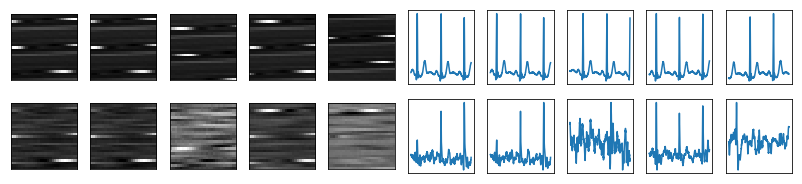

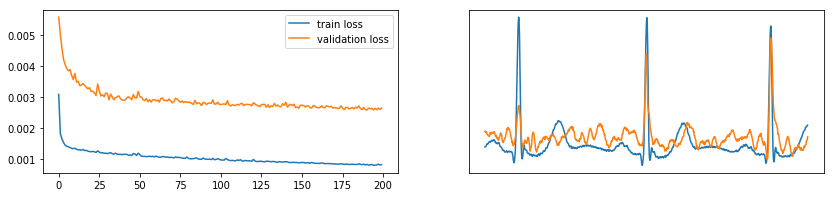

In [796]:
h = fit_encoders(encoders, x_train, x_test, epochs=200, filename='784_256_128_64.h5', load_prev=True, verbose=1)

('Evaluating model with fc:', '[3]')


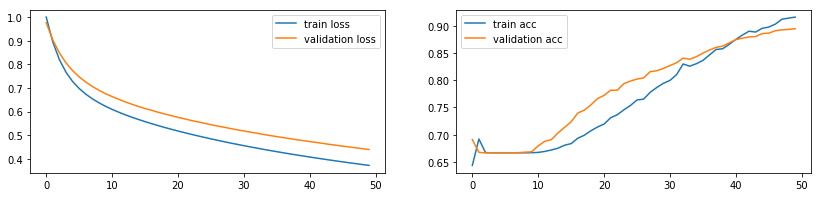

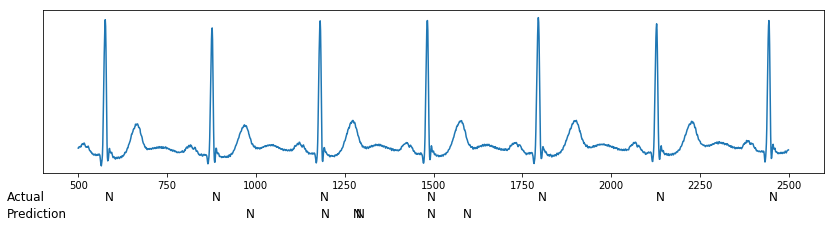

('Evaluating model with fc:', '[10, 3]')


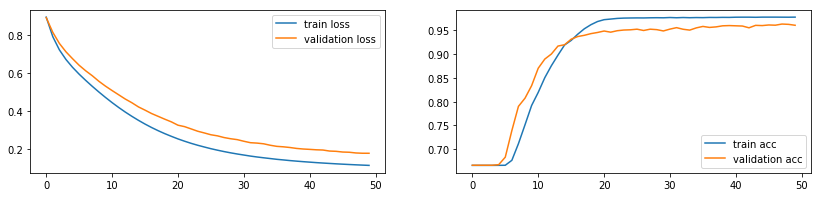

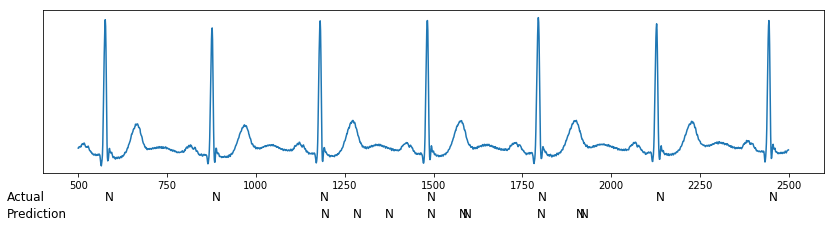

('Evaluating model with fc:', '[32, 3]')


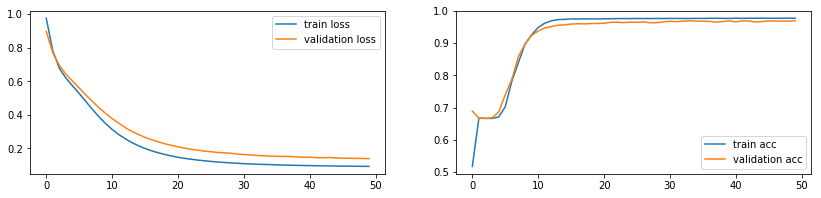

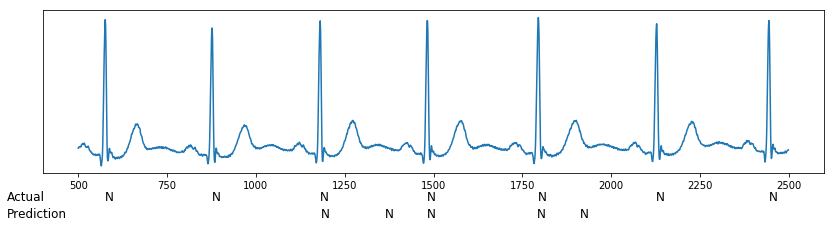

('Evaluating model with fc:', '[64, 3]')


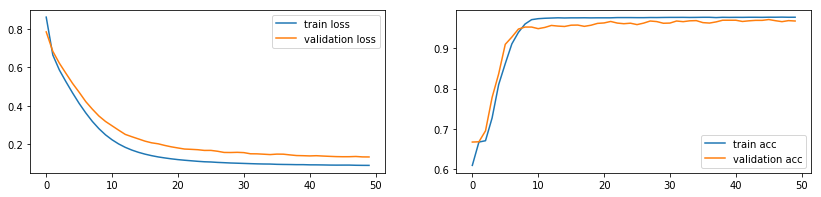

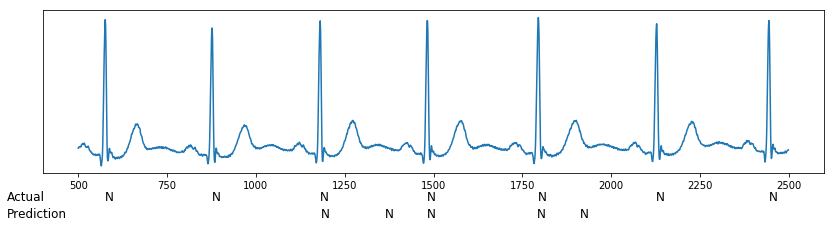

In [797]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=50)

### 784 512 64

In [799]:
encoders = create_encoders(784, [512], 128)

Successfully loaded weights
Train on 12387 samples, validate on 6246 samples
Epoch 1/2
12387/12387 [==============================] - 5s - loss: 0.0035 - acc: 0.0372 - val_loss: 0.0044 - val_acc: 0.0018
Epoch 2/2
12387/12387 [==============================] - 2s - loss: 0.0018 - acc: 0.0500 - val_loss: 0.0040 - val_acc: 0.0037


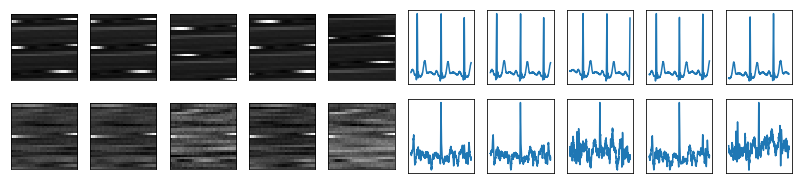

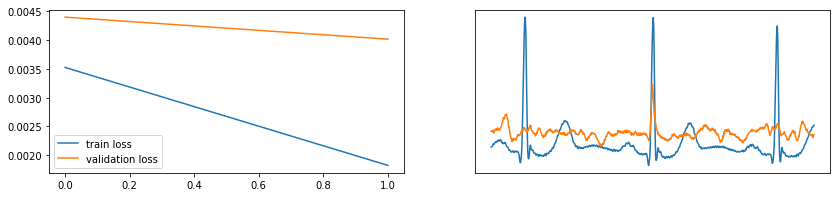

In [802]:
fit_encoders(encoders, x_train, x_test, epochs=2, filename='784_512_64.h5', load_prev=True, verbose=1)

Evaluating model with fc: [3]


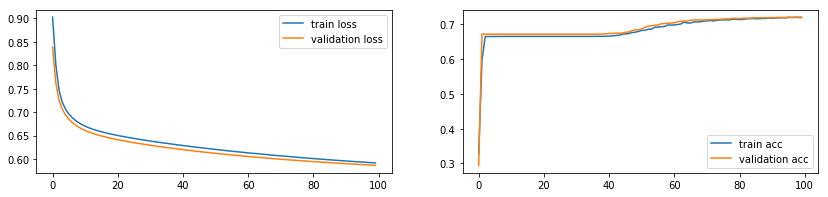

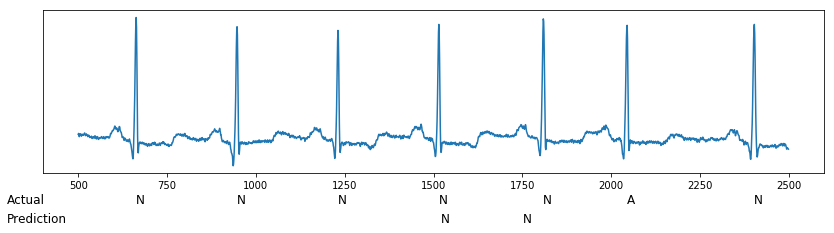

Evaluating model with fc: [10, 3]


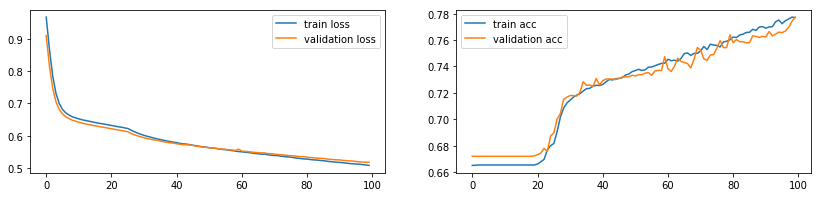

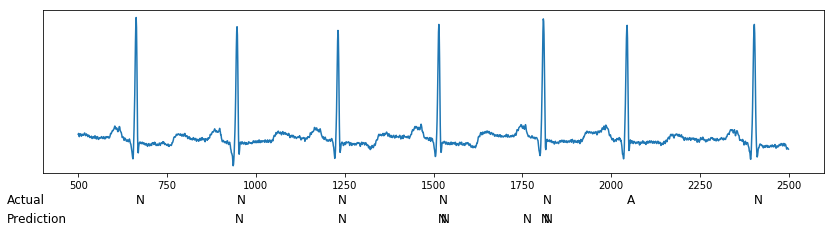

Evaluating model with fc: [32, 3]


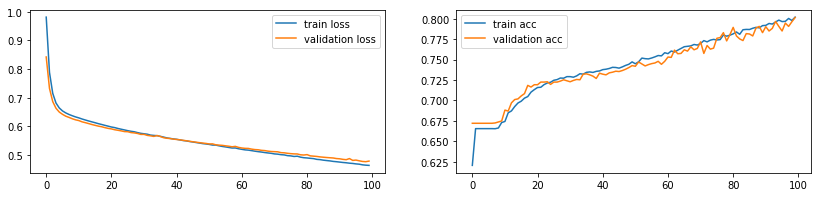

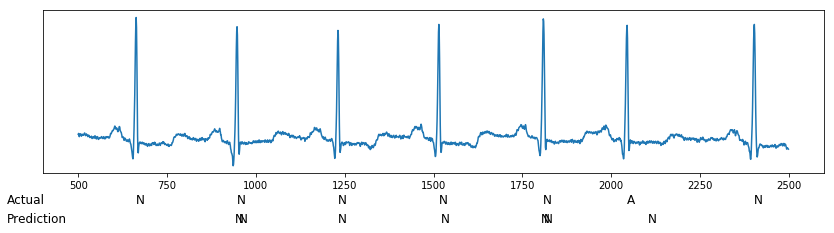

Evaluating model with fc: [64, 3]


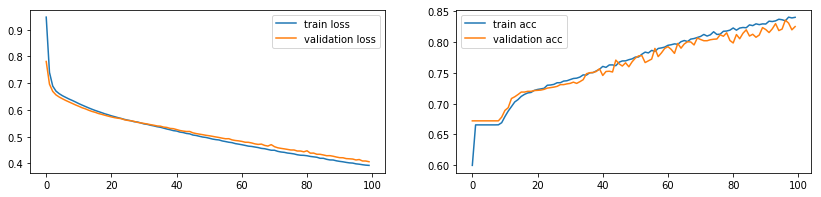

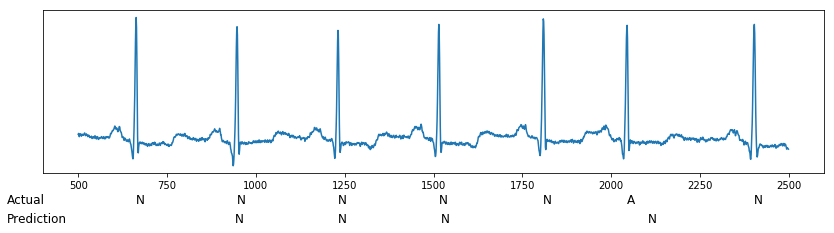

In [113]:
r = evaluate_fc(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

### CONV

In [775]:
encoders = create_conv_encoders()

("Can't load weights to model", ValueError('You are trying to load a weight file containing 7 layers into a model with 10 layers.',))
Train on 3303 samples, validate on 826 samples
Epoch 1/2
3303/3303 [==============================] - 7s - loss: 0.0094 - acc: 1.1585e-06 - val_loss: 0.0048 - val_acc: 3.0884e-06
Epoch 2/2
3303/3303 [==============================] - 5s - loss: 0.0041 - acc: 2.3170e-06 - val_loss: 0.0050 - val_acc: 3.0884e-06


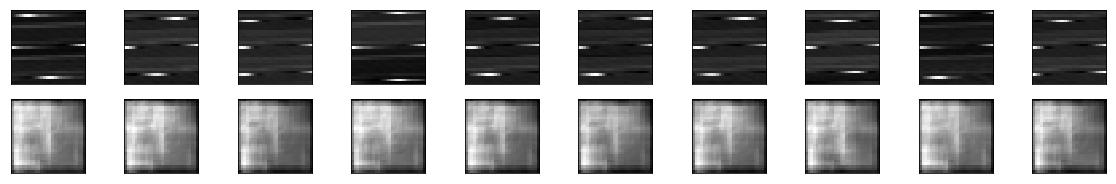

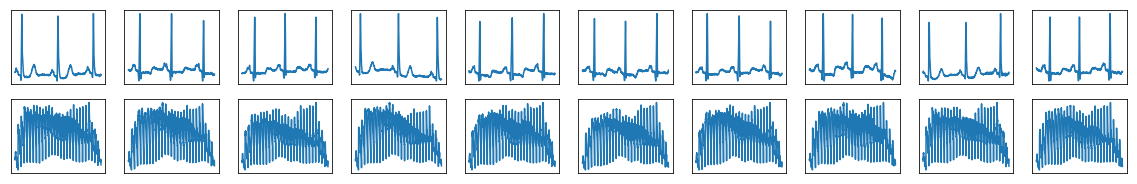

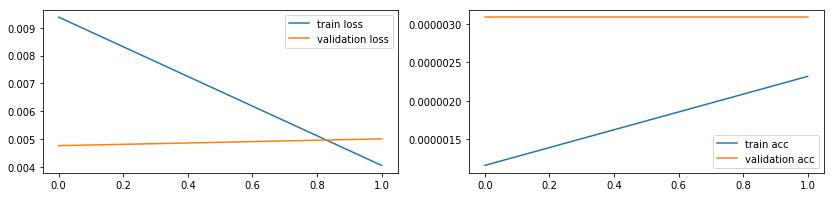

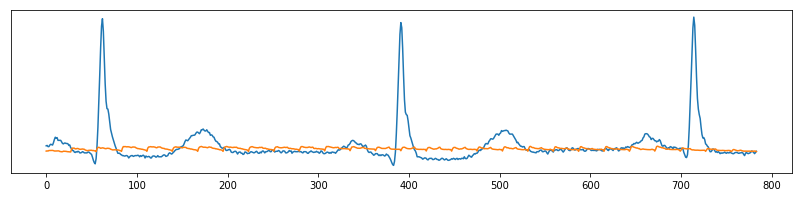

In [776]:
h=fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='bn_conv16_8_8.h5', load_prev=True, verbose=1)

In [780]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

(None, 4, 4, 8)
('Evaluating model with fc:', '[3]')
[(None, 28, 28, 1), (None, 4, 4, 8), (None, 128), (None, 3)]


KeyboardInterrupt: 

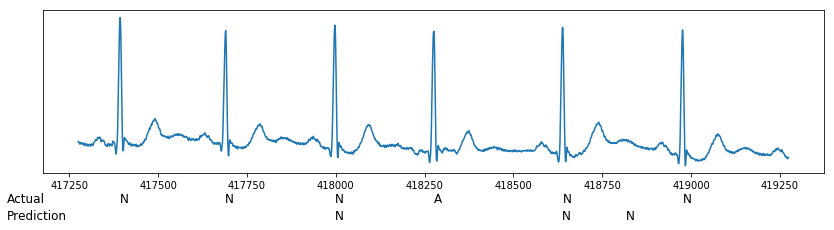

In [150]:
plot_validation_diagram(r[-1], lb.classes_, ann, sig, 418275-1000, 418275 + 1000) 

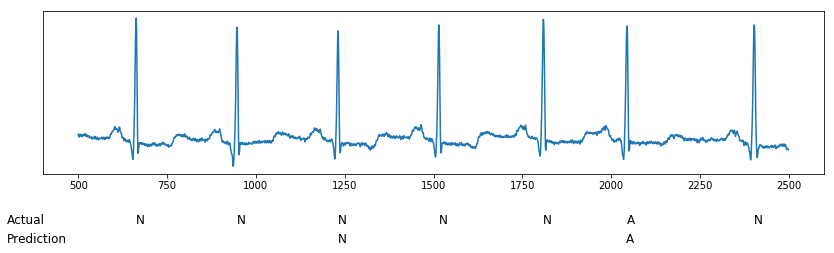

In [153]:
plot_validation_diagram(r[-1], lb.classes_, ann, sig, 500, 2500) 

### Smooth data and bn

Can't load weights to model Unable to open file (Unable to open file: name = 'bn_smooth_data.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Train on 2235 samples, validate on 2235 samples
Epoch 1/1000
2235/2235 [==============================] - 1s - loss: 0.0167 - val_loss: 0.0084
Epoch 2/1000
2235/2235 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0082
Epoch 3/1000
2235/2235 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0080
Epoch 4/1000
2235/2235 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0080
Epoch 5/1000
2235/2235 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0079
Epoch 6/1000
2235/2235 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0079
Epoch 7/1000
2235/2235 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0078
Epoch 8/1000
2235/2235 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0078
Epoch 9/1000
2

2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0037
Epoch 85/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 86/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 87/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 88/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0035
Epoch 89/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 90/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 91/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 92/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 93/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 94/1000
2235/2235 [=============================

2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 253/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 254/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 255/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 256/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 257/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 258/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 259/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 260/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 261/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 262/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 421/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 422/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 423/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 424/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 425/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 426/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 427/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 428/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 429/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 430/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 9.1158e-04 - val_loss: 9.1698e-04
Epoch 581/1000
2235/2235 [==============================] - 0s - loss: 9.1125e-04 - val_loss: 9.1629e-04
Epoch 582/1000
2235/2235 [==============================] - 0s - loss: 9.1033e-04 - val_loss: 9.1134e-04
Epoch 583/1000
2235/2235 [==============================] - 0s - loss: 9.0921e-04 - val_loss: 9.1801e-04
Epoch 584/1000
2235/2235 [==============================] - 0s - loss: 9.0861e-04 - val_loss: 9.1092e-04
Epoch 585/1000
2235/2235 [==============================] - 0s - loss: 9.0807e-04 - val_loss: 9.1028e-04
Epoch 586/1000
2235/2235 [==============================] - 0s - loss: 9.0717e-04 - val_loss: 9.1201e-04
Epoch 587/1000
2235/2235 [==============================] - 0s - loss: 9.0602e-04 - val_loss: 9.1479e-04
Epoch 588/1000
2235/2235 [==============================] - 0s - loss: 9.0521e-04 - val_loss: 9.1107e-04
Epoch 589/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 8.0933e-04 - val_loss: 8.1062e-04
Epoch 737/1000
2235/2235 [==============================] - 0s - loss: 8.0885e-04 - val_loss: 8.1080e-04
Epoch 738/1000
2235/2235 [==============================] - 0s - loss: 8.0818e-04 - val_loss: 8.1295e-04
Epoch 739/1000
2235/2235 [==============================] - 0s - loss: 8.0765e-04 - val_loss: 8.0920e-04
Epoch 740/1000
2235/2235 [==============================] - 0s - loss: 8.0735e-04 - val_loss: 8.0786e-04
Epoch 741/1000
2235/2235 [==============================] - 0s - loss: 8.0657e-04 - val_loss: 8.0956e-04
Epoch 742/1000
2235/2235 [==============================] - 0s - loss: 8.0615e-04 - val_loss: 8.0733e-04
Epoch 743/1000
2235/2235 [==============================] - 0s - loss: 8.0540e-04 - val_loss: 8.1024e-04
Epoch 744/1000
2235/2235 [==============================] - 0s - loss: 8.0509e-04 - val_loss: 8.0603e-04
Epoch 745/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 7.3131e-04 - val_loss: 7.3064e-04
Epoch 893/1000
2235/2235 [==============================] - 0s - loss: 7.3046e-04 - val_loss: 7.3061e-04
Epoch 894/1000
2235/2235 [==============================] - 0s - loss: 7.2993e-04 - val_loss: 7.2975e-04
Epoch 895/1000
2235/2235 [==============================] - 0s - loss: 7.2927e-04 - val_loss: 7.3114e-04
Epoch 896/1000
2235/2235 [==============================] - 0s - loss: 7.2912e-04 - val_loss: 7.3010e-04
Epoch 897/1000
2235/2235 [==============================] - 0s - loss: 7.2835e-04 - val_loss: 7.2863e-04
Epoch 898/1000
2235/2235 [==============================] - 0s - loss: 7.2820e-04 - val_loss: 7.2792e-04
Epoch 899/1000
2235/2235 [==============================] - 0s - loss: 7.2780e-04 - val_loss: 7.2789e-04
Epoch 900/1000
2235/2235 [==============================] - 0s - loss: 7.2720e-04 - val_loss: 7.2774e-04
Epoch 901/1000
2235/2235 [==============================] - 0s - loss:

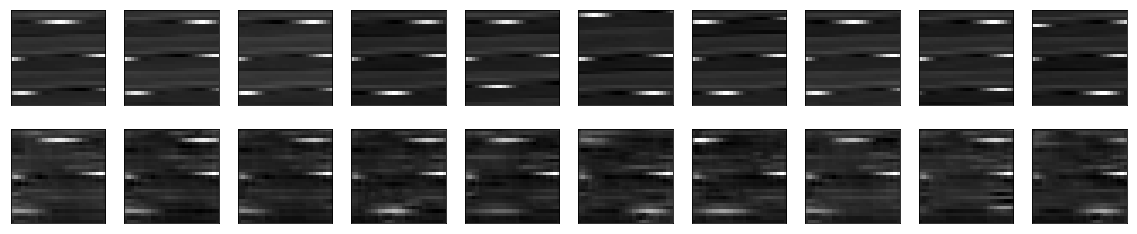

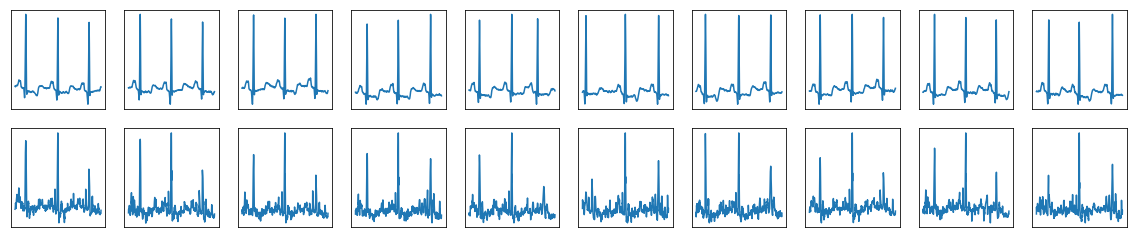

CPU times: user 10min 59s, sys: 1min 43s, total: 12min 43s
Wall time: 13min 32s


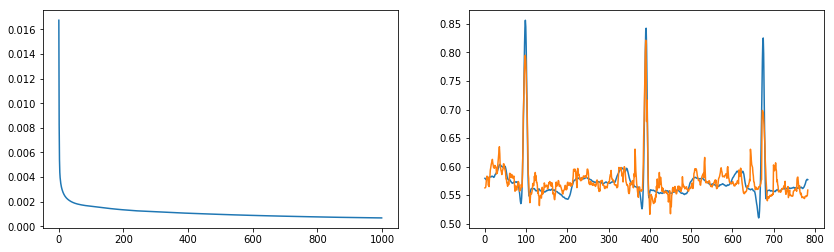

In [64]:
%time run(*create_conv_encoders(), shape=(28,28,1), weights_filename = 'bn_smooth_data.h5', epochs=1000)